# House Prices Prediction

### Índice
- Panorama
- Pre processamento
    - Imputações
    - Label Encoding
- Análise de variáveis categóricas
- Análise de variáveis numéricas
- Detecção de outliers

## Import the library

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import chi2_contingency, chi2, kruskal
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
import tensorflow_decision_forests as tfdf


## Load the dataset


In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


In [3]:
train = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
test = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')

train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


### Panorama: Um olhar antes das imputações

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [5]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1459 non-null   int64  
 1   MSSubClass     1459 non-null   int64  
 2   MSZoning       1455 non-null   object 
 3   LotFrontage    1232 non-null   float64
 4   LotArea        1459 non-null   int64  
 5   Street         1459 non-null   object 
 6   Alley          107 non-null    object 
 7   LotShape       1459 non-null   object 
 8   LandContour    1459 non-null   object 
 9   Utilities      1457 non-null   object 
 10  LotConfig      1459 non-null   object 
 11  LandSlope      1459 non-null   object 
 12  Neighborhood   1459 non-null   object 
 13  Condition1     1459 non-null   object 
 14  Condition2     1459 non-null   object 
 15  BldgType       1459 non-null   object 
 16  HouseStyle     1459 non-null   object 
 17  OverallQual    1459 non-null   int64  
 18  OverallC

## Gráficos de distribuição de variáveis numéricas


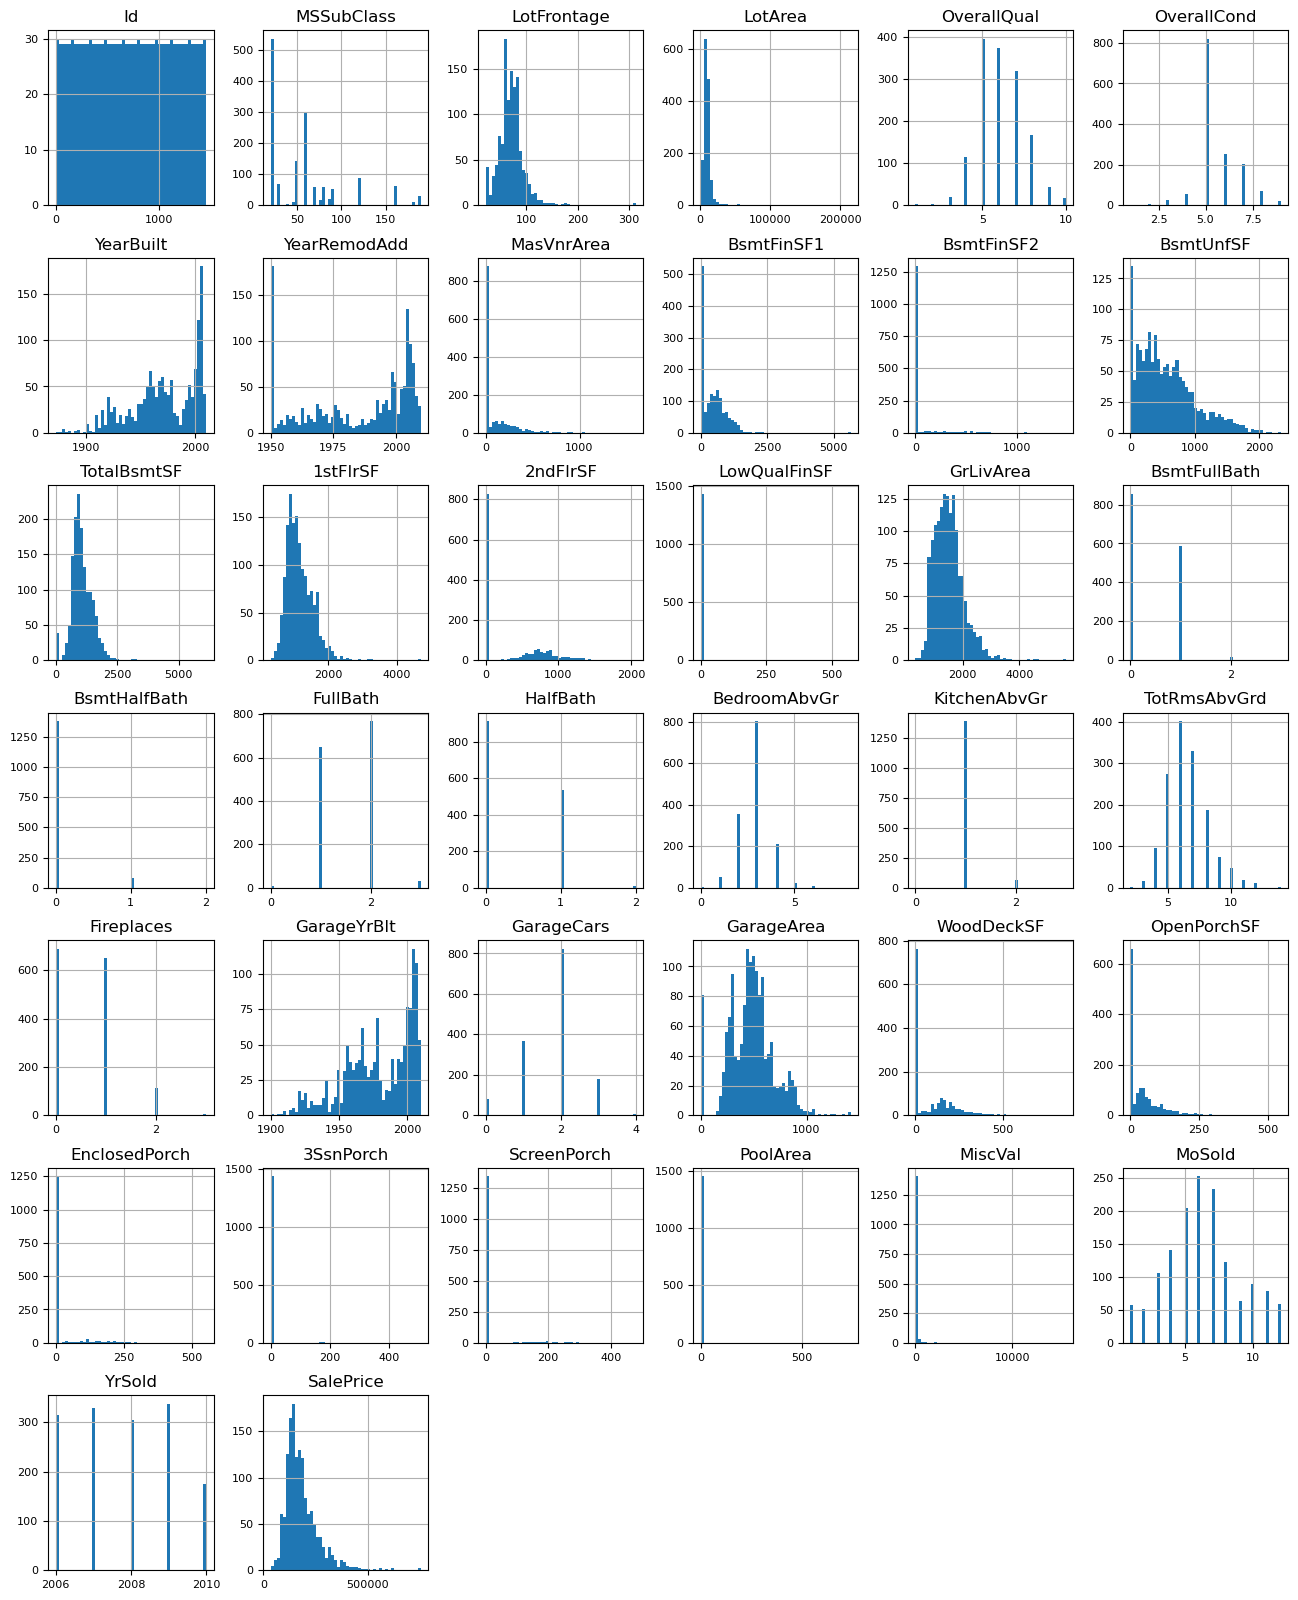

In [6]:
df_num = train.select_dtypes(include = ['float64', 'int64'])
df_num.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8);


## Imputações

### Sobre a variável garagem e seus associados:
- GarageType: Categorico
- GarageYrBlt: Numerico
- GarageFinish: Categorico
- GarageQual: Categorico
- GarageCond: Categorico
<br>Seus valores nulos se referem à falta de garagem, portanto, para tratar de maneira adequada, iremos imputar zero para as variáveis numéricas e 'No Garage' para as variáveis categóricas

In [7]:

# Variáveis de garagem
garage_vars_categorical = ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']
garage_vars_numeric = ['GarageYrBlt']

# Função para imputar valores ausentes
def impute_garage_variables(train, test):
    for var in garage_vars_categorical:
        if var in train.columns:
            train[var].fillna('None', inplace=True)
            test[var].fillna('None', inplace=True)

    for var in garage_vars_numeric:
        if var in train.columns:
            train[var].fillna(0, inplace=True)
            test[var].fillna(0, inplace=True)

# Aplicar a função aos DataFrames de treino e teste
impute_garage_variables(train, test)

# Verificar resultados
print("Treino - Valores únicos após imputação:")
for var in garage_vars_categorical + garage_vars_numeric:
    print(f"{var}: {train[var].unique()}")

print("\nTeste - Valores únicos após imputação:")
for var in garage_vars_categorical + garage_vars_numeric:
    print(f"{var}: {test[var].unique()}")

Treino - Valores únicos após imputação:
GarageType: ['Attchd' 'Detchd' 'BuiltIn' 'CarPort' 'None' 'Basment' '2Types']
GarageFinish: ['RFn' 'Unf' 'Fin' 'None']
GarageQual: ['TA' 'Fa' 'Gd' 'None' 'Ex' 'Po']
GarageCond: ['TA' 'Fa' 'None' 'Gd' 'Po' 'Ex']
GarageYrBlt: [2003. 1976. 2001. 1998. 2000. 1993. 2004. 1973. 1931. 1939. 1965. 2005.
 1962. 2006. 1960. 1991. 1970. 1967. 1958. 1930. 2002. 1968. 2007. 2008.
 1957. 1920. 1966. 1959. 1995. 1954. 1953.    0. 1983. 1977. 1997. 1985.
 1963. 1981. 1964. 1999. 1935. 1990. 1945. 1987. 1989. 1915. 1956. 1948.
 1974. 2009. 1950. 1961. 1921. 1900. 1979. 1951. 1969. 1936. 1975. 1971.
 1923. 1984. 1926. 1955. 1986. 1988. 1916. 1932. 1972. 1918. 1980. 1924.
 1996. 1940. 1949. 1994. 1910. 1978. 1982. 1992. 1925. 1941. 2010. 1927.
 1947. 1937. 1942. 1938. 1952. 1928. 1922. 1934. 1906. 1914. 1946. 1908.
 1929. 1933.]

Teste - Valores únicos após imputação:
GarageType: ['Attchd' 'Detchd' 'BuiltIn' 'None' 'Basment' '2Types' 'CarPort']
GarageFinish: ['Unf'

### Sobre a Variavel Bsmt
- BsmtQual - categorico (NA indica que nao há bsmt)
- BsmtCond - Categorico (NA indica que nao há bsmt)
- BsmtExposure - Categorico (NA indica que nao há bsmt)
- BsmtFinType1 e 2 - Categorico (NA indica que nao há bsmt)


In [8]:
basement_variables = ['BsmtQual', 'BsmtCond','BsmtExposure','BsmtFinType1', 'BsmtFinType2']
# Função para imputar valores ausentes
def impute_basement_variables(train, test):
    for var in basement_variables:
        if var in train.columns:
            train[var].fillna('None', inplace=True)
            test[var].fillna('None', inplace=True)

# Aplicar a função aos DataFrames de treino e teste
impute_basement_variables(train, test)

# Verificar resultados
print("Treino - Valores únicos após imputação:")
for var in basement_variables:
    print(f"{var}: {train[var].unique()}")

print("\nTeste - Valores únicos após imputação:")
for var in basement_variables:
    print(f"{var}: {test[var].unique()}")

Treino - Valores únicos após imputação:
BsmtQual: ['Gd' 'TA' 'Ex' 'None' 'Fa']
BsmtCond: ['TA' 'Gd' 'None' 'Fa' 'Po']
BsmtExposure: ['No' 'Gd' 'Mn' 'Av' 'None']
BsmtFinType1: ['GLQ' 'ALQ' 'Unf' 'Rec' 'BLQ' 'None' 'LwQ']
BsmtFinType2: ['Unf' 'BLQ' 'None' 'ALQ' 'Rec' 'LwQ' 'GLQ']

Teste - Valores únicos após imputação:
BsmtQual: ['TA' 'Gd' 'Ex' 'Fa' 'None']
BsmtCond: ['TA' 'Po' 'Fa' 'Gd' 'None']
BsmtExposure: ['No' 'Gd' 'Mn' 'Av' 'None']
BsmtFinType1: ['Rec' 'ALQ' 'GLQ' 'Unf' 'BLQ' 'LwQ' 'None']
BsmtFinType2: ['LwQ' 'Unf' 'Rec' 'BLQ' 'GLQ' 'ALQ' 'None']


### - PoolQC, FireplaceQC, Alley, Fence e MiscFeatures nulos significam sem essas características, iremos imputar com None para mantermos o padrão

In [9]:
leftover_variables = ['PoolQC', 'FireplaceQu', 'Alley', 'Fence', 'MiscFeature', 'MasVnrType']

def impute_leftover_variables(train, test):
    for var in leftover_variables:
        if var in train.columns:
            train[var].fillna('None', inplace=True)
            test[var].fillna('None', inplace=True)
        
    
# Aplicar a função aos DataFrames de treino e teste
impute_leftover_variables(train, test)

# Verificar resultados
print("Treino - Valores únicos após imputação:")
for var in leftover_variables:
    print(f"{var}: {train[var].unique()}")

print("\nTeste - Valores únicos após imputação:")
for var in leftover_variables:
    print(f"{var}: {test[var].unique()}")

Treino - Valores únicos após imputação:
PoolQC: ['None' 'Ex' 'Fa' 'Gd']
FireplaceQu: ['None' 'TA' 'Gd' 'Fa' 'Ex' 'Po']
Alley: ['None' 'Grvl' 'Pave']
Fence: ['None' 'MnPrv' 'GdWo' 'GdPrv' 'MnWw']
MiscFeature: ['None' 'Shed' 'Gar2' 'Othr' 'TenC']
MasVnrType: ['BrkFace' 'None' 'Stone' 'BrkCmn']

Teste - Valores únicos após imputação:
PoolQC: ['None' 'Ex' 'Gd']
FireplaceQu: ['None' 'TA' 'Gd' 'Po' 'Fa' 'Ex']
Alley: ['None' 'Pave' 'Grvl']
Fence: ['MnPrv' 'None' 'GdPrv' 'GdWo' 'MnWw']
MiscFeature: ['None' 'Gar2' 'Shed' 'Othr']
MasVnrType: ['None' 'BrkFace' 'Stone' 'BrkCmn']


### Sobre MasVnr:
- MasVnrType: NA indica ausencia de MasVnrType
- MasVnrArea: Todas as NA batem com NAs acima, chequei a mão

In [10]:
mas_vnr_categorical = 'MasVnrType'
mas_vnr_numeric = 'MasVnrArea'

# Função para imputar valores ausentes
def impute_mas_vnr(train, test):
    train[mas_vnr_categorical].fillna('None', inplace=True)
    test[mas_vnr_categorical].fillna('None', inplace=True)
    
    train[mas_vnr_numeric].fillna(0, inplace=True)
    test[mas_vnr_numeric].fillna(0, inplace=True)

# Aplicar a função aos DataFrames de treino e teste
impute_mas_vnr(train, test)

# Verificar resultados
print("Treino - Valores únicos após imputação:")
print(train[[mas_vnr_categorical, mas_vnr_numeric]].drop_duplicates())

print("\nTeste - Valores únicos após imputação:")
print(test[[mas_vnr_categorical, mas_vnr_numeric]].drop_duplicates())

Treino - Valores únicos após imputação:
     MasVnrType  MasVnrArea
0       BrkFace       196.0
1          None         0.0
2       BrkFace       162.0
4       BrkFace       350.0
6         Stone       186.0
...         ...         ...
1437      Stone       426.0
1439    BrkFace        96.0
1447    BrkFace       438.0
1451      Stone       194.0
1456      Stone       119.0

[401 rows x 2 columns]

Teste - Valores únicos após imputação:
     MasVnrType  MasVnrArea
0          None         0.0
1       BrkFace       108.0
3       BrkFace        20.0
11      BrkFace       504.0
12      BrkFace       492.0
...         ...         ...
1399    BrkFace       355.0
1425    BrkFace       405.0
1430    BrkFace       327.0
1439    BrkFace       257.0
1443    BrkFace       382.0

[370 rows x 2 columns]


### Sobre LotFrontage: como é possível ver nos gráficos, sua distribuição não é nem perto da normal, por isso, iremos imputar com a mediana

In [11]:
frontage = ['LotFrontage']

def impute_frontage(train, test):
    for var in frontage:
        if var in train.columns:
            median = train[var].median()
            train[var].fillna(median, inplace=True)
            test[var].fillna(median, inplace=True)

# Aplicar a função aos DataFrames de treino e teste
impute_frontage(train, test)

# Verificar resultados
print("Treino - Valores únicos após imputação:")
for var in frontage:
    print(f"{var}: {train[var].unique()}")

print("\nTeste - Valores únicos após imputação:")
for var in frontage:
    print(f"{var}: {test[var].unique()}")

Treino - Valores únicos após imputação:
LotFrontage: [ 65.  80.  68.  60.  84.  85.  75.  69.  51.  50.  70.  91.  72.  66.
 101.  57.  44. 110.  98.  47. 108. 112.  74. 115.  61.  48.  33.  52.
 100.  24.  89.  63.  76.  81.  95.  21.  32.  78. 121. 122.  40. 105.
  73.  77.  64.  94.  34.  90.  55.  88.  82.  71. 120. 107.  92. 134.
  62.  86. 141.  97.  54.  41.  79. 174.  99.  67.  83.  43. 103.  93.
  30. 129. 140.  35.  37. 118.  87. 116. 150. 111.  49.  96.  59.  36.
  56. 102.  58.  38. 109. 130.  53. 137.  45. 106. 104.  42.  39. 144.
 114. 128. 149. 313. 168. 182. 138. 160. 152. 124. 153.  46.]

Teste - Valores únicos após imputação:
LotFrontage: [ 80.  81.  74.  78.  43.  75.  69.  63.  85.  70.  26.  21.  24. 102.
  94.  90.  79. 110. 105.  41. 100.  67.  60.  73.  92.  84.  39.  88.
  25.  30.  57.  68.  98. 120.  87. 119.  65.  56.  50.  53.  52.  51.
  72.  86. 124.  44.  83.  64.  82.  38.  89.  35.  58.  66.  93.  31.
  76.  28.  61.  95. 129.  59.  77.  96.  47.  34. 

### Checando os datasets para ver se foram imputados corretamente

In [12]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1460 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          1460 non-null   object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [13]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1459 non-null   int64  
 1   MSSubClass     1459 non-null   int64  
 2   MSZoning       1455 non-null   object 
 3   LotFrontage    1459 non-null   float64
 4   LotArea        1459 non-null   int64  
 5   Street         1459 non-null   object 
 6   Alley          1459 non-null   object 
 7   LotShape       1459 non-null   object 
 8   LandContour    1459 non-null   object 
 9   Utilities      1457 non-null   object 
 10  LotConfig      1459 non-null   object 
 11  LandSlope      1459 non-null   object 
 12  Neighborhood   1459 non-null   object 
 13  Condition1     1459 non-null   object 
 14  Condition2     1459 non-null   object 
 15  BldgType       1459 non-null   object 
 16  HouseStyle     1459 non-null   object 
 17  OverallQual    1459 non-null   int64  
 18  OverallC

### Aparentemente, algumas entradas ficaram faltando, como MSZoning, Utilities, Exterior1st, Exterior2nd, BsmtFinSF1,BsmtFinSF2,BsmtUnfSF  ,TotalBsmtSF, BsmtFullBath, BsmtHalfBath, KitchenQual, Functional, SaleType, GarageCars, GarageArea, BsmtUnfSF

In [14]:
import pandas as pd

# Assuming you have a training DataFrame named `train`
# Calculate the mode for each column in the training dataset
Mode = test.mode().iloc[0]

# Reset the index of the Mode DataFrame
Mode.reset_index(drop=True, inplace=True)

# Define the list of leftover test variables (replace with your actual variables)
leftover_test_variables = ['MSZoning', 'Utilities', 'Exterior2nd', 'Exterior1st', 'BsmtFinSF1', 
                           'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath',
                           'KitchenQual', 'Functional', 'SaleType', 'GarageCars', 'GarageArea', 'BsmtUnfSF']

# Function to impute missing values in the test dataset
def impute_leftover_test_variables(test):
    for var in leftover_test_variables:
        if var in test.columns:
            if var in Mode.index:
                test[var].fillna(Mode[var], inplace=True)
            else:
                # If the variable is not in Mode, fill with the most common value in the column
                mode_val = test[var].mode()[0]
                test[var].fillna(mode_val, inplace=True)

# Assuming you have a test DataFrame named `test`
# Apply the function to the test DataFrame
impute_leftover_test_variables(test)

test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1459 non-null   int64  
 1   MSSubClass     1459 non-null   int64  
 2   MSZoning       1459 non-null   object 
 3   LotFrontage    1459 non-null   float64
 4   LotArea        1459 non-null   int64  
 5   Street         1459 non-null   object 
 6   Alley          1459 non-null   object 
 7   LotShape       1459 non-null   object 
 8   LandContour    1459 non-null   object 
 9   Utilities      1459 non-null   object 
 10  LotConfig      1459 non-null   object 
 11  LandSlope      1459 non-null   object 
 12  Neighborhood   1459 non-null   object 
 13  Condition1     1459 non-null   object 
 14  Condition2     1459 non-null   object 
 15  BldgType       1459 non-null   object 
 16  HouseStyle     1459 non-null   object 
 17  OverallQual    1459 non-null   int64  
 18  OverallC

In [15]:
train_num = train.select_dtypes(include=['float64', 'int64'])
train_cat = train.select_dtypes(exclude=['float64', 'int64'])
test_num = test.select_dtypes(include=['float64', 'int64'])
test_cat = test.select_dtypes(exclude=['float64', 'int64'])

In [16]:
train_cat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 43 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MSZoning       1460 non-null   object
 1   Street         1460 non-null   object
 2   Alley          1460 non-null   object
 3   LotShape       1460 non-null   object
 4   LandContour    1460 non-null   object
 5   Utilities      1460 non-null   object
 6   LotConfig      1460 non-null   object
 7   LandSlope      1460 non-null   object
 8   Neighborhood   1460 non-null   object
 9   Condition1     1460 non-null   object
 10  Condition2     1460 non-null   object
 11  BldgType       1460 non-null   object
 12  HouseStyle     1460 non-null   object
 13  RoofStyle      1460 non-null   object
 14  RoofMatl       1460 non-null   object
 15  Exterior1st    1460 non-null   object
 16  Exterior2nd    1460 non-null   object
 17  MasVnrType     1460 non-null   object
 18  ExterQual      1460 non-null

In [17]:
test_cat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 43 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MSZoning       1459 non-null   object
 1   Street         1459 non-null   object
 2   Alley          1459 non-null   object
 3   LotShape       1459 non-null   object
 4   LandContour    1459 non-null   object
 5   Utilities      1459 non-null   object
 6   LotConfig      1459 non-null   object
 7   LandSlope      1459 non-null   object
 8   Neighborhood   1459 non-null   object
 9   Condition1     1459 non-null   object
 10  Condition2     1459 non-null   object
 11  BldgType       1459 non-null   object
 12  HouseStyle     1459 non-null   object
 13  RoofStyle      1459 non-null   object
 14  RoofMatl       1459 non-null   object
 15  Exterior1st    1459 non-null   object
 16  Exterior2nd    1459 non-null   object
 17  MasVnrType     1459 non-null   object
 18  ExterQual      1459 non-null

## Testes de hipótese: Teste Chi-Quadrado


In [18]:
significance_level = 0.05
target_variable = 'SalePrice'
# Function to perform Chi-Squared test
def chi_squared_test(train, target='SalePrice', significance_level=0.05):
    results = {}
    train_cat = train.select_dtypes(include=['object'])  # Selecting only categorical columns
    for column in train_cat:
        contingency_table = pd.crosstab(train_cat[column], train[target])
        chi2_stat, p, dof, ex = chi2_contingency(contingency_table)
        critical_value = chi2.ppf(1 - significance_level, dof)
        results[column] = {'chi2': chi2_stat, 'p_value': p, 'dof': dof, 'critical_value': critical_value}
    return results

# Perform the Chi-Squared tests on the training set
chi2_results = chi_squared_test(train, target_variable)

# Display results
for column, result in chi2_results.items():
    print(f"Variable: {column}")
    print(f"  Chi2: {result['chi2']}")
    print(f"  p-value: {result['p_value']}")
    print(f"  Degrees of Freedom: {result['dof']}")
    print(f"  Critical Value: {result['critical_value']}")
    if result['p_value'] < significance_level and result['chi2'] > result['critical_value']:
        print(f"  {column} is correlated with {target_variable}")
    elif result['p_value'] >= significance_level and result['chi2'] <= result['critical_value']:
        print(f"  {column} is NOT correlated with {target_variable}")
    else:
        print('  Results are conflicting')
    print("\n")

Variable: MSZoning
  Chi2: 3147.8911158183737
  p-value: 4.3483250606822396e-11
  Degrees of Freedom: 2648
  Critical Value: 2768.8281535489073
  MSZoning is correlated with SalePrice


Variable: Street
  Chi2: 888.3129945096931
  p-value: 8.338870380464053e-09
  Degrees of Freedom: 662
  Critical Value: 722.9662553606306
  Street is correlated with SalePrice


Variable: Alley
  Chi2: 1233.0758732766717
  p-value: 0.9637567934663973
  Degrees of Freedom: 1324
  Critical Value: 1409.7637498147142
  Alley is NOT correlated with SalePrice


Variable: LotShape
  Chi2: 2446.2353573800365
  p-value: 4.724729155980402e-12
  Degrees of Freedom: 1986
  Critical Value: 2090.7894487834265
  LotShape is correlated with SalePrice


Variable: LandContour
  Chi2: 2072.335508433759
  p-value: 0.08674645041917711
  Degrees of Freedom: 1986
  Critical Value: 2090.7894487834265
  LandContour is NOT correlated with SalePrice


Variable: Utilities
  Chi2: 242.49942883253368
  p-value: 1.0
  Degrees of Free

## Label Encoding

In [19]:
# Initialize a dictionary to hold the label encoders
label_encoders = {}

# Apply label encoding to training data
encoded_cat_train = pd.DataFrame()
for col in train_cat:
    le = LabelEncoder()
    encoded_values = le.fit_transform(train[col])
    encoded_cat_train[col] = encoded_values
    label_encoders[col] = le

# Apply the same label encoders to the test data
encoded_cat_test = pd.DataFrame()
for col in test_cat:
    le = label_encoders[col]
    encoded_values = le.transform(test[col])
    encoded_cat_test[col] = encoded_values

### Seleção de features categóricas

In [20]:
new_train_cat = pd.DataFrame()

# Iterate through the correlated variables and concatenate them into the new DataFrame
for column, result in chi2_results.items():
    if result['p_value'] < significance_level and result['chi2'] > result['critical_value']:
        correlated_var = train[column]
        new_train_cat[column] = correlated_var

# Display the new DataFrame
print(new_train_cat)

     MSZoning Street LotShape LotConfig Neighborhood MasVnrType ExterQual  \
0          RL   Pave      Reg    Inside      CollgCr    BrkFace        Gd   
1          RL   Pave      Reg       FR2      Veenker       None        TA   
2          RL   Pave      IR1    Inside      CollgCr    BrkFace        Gd   
3          RL   Pave      IR1    Corner      Crawfor       None        TA   
4          RL   Pave      IR1       FR2      NoRidge    BrkFace        Gd   
...       ...    ...      ...       ...          ...        ...       ...   
1455       RL   Pave      Reg    Inside      Gilbert       None        TA   
1456       RL   Pave      Reg    Inside       NWAmes      Stone        TA   
1457       RL   Pave      Reg    Inside      Crawfor       None        Ex   
1458       RL   Pave      Reg    Inside        NAmes       None        TA   
1459       RL   Pave      Reg    Inside      Edwards       None        Gd   

     ExterCond Foundation BsmtQual BsmtCond BsmtExposure Heating CentralAir

### Categorical Test variables

In [21]:
# Step 1: Select categorical features from the train set
train_cat = train.select_dtypes(include=['object'])
new_train_cat = train_cat  # assuming you already have this step

# Step 2: Select the same categorical features from the test set
test_cat = test.select_dtypes(include=['object'])
categorical_columns = new_train_cat.columns
new_test_cat = test_cat[categorical_columns]

# Optionally, print the first few rows to verify
print(new_test_cat.head())

  MSZoning Street Alley LotShape LandContour Utilities LotConfig LandSlope  \
0       RH   Pave  None      Reg         Lvl    AllPub    Inside       Gtl   
1       RL   Pave  None      IR1         Lvl    AllPub    Corner       Gtl   
2       RL   Pave  None      IR1         Lvl    AllPub    Inside       Gtl   
3       RL   Pave  None      IR1         Lvl    AllPub    Inside       Gtl   
4       RL   Pave  None      IR1         HLS    AllPub    Inside       Gtl   

  Neighborhood Condition1  ... GarageType GarageFinish GarageQual GarageCond  \
0        NAmes      Feedr  ...     Attchd          Unf         TA         TA   
1        NAmes       Norm  ...     Attchd          Unf         TA         TA   
2      Gilbert       Norm  ...     Attchd          Fin         TA         TA   
3      Gilbert       Norm  ...     Attchd          Fin         TA         TA   
4      StoneBr       Norm  ...     Attchd          RFn         TA         TA   

  PavedDrive PoolQC  Fence MiscFeature SaleType Sa

## Distribuição de variáveis numéricas


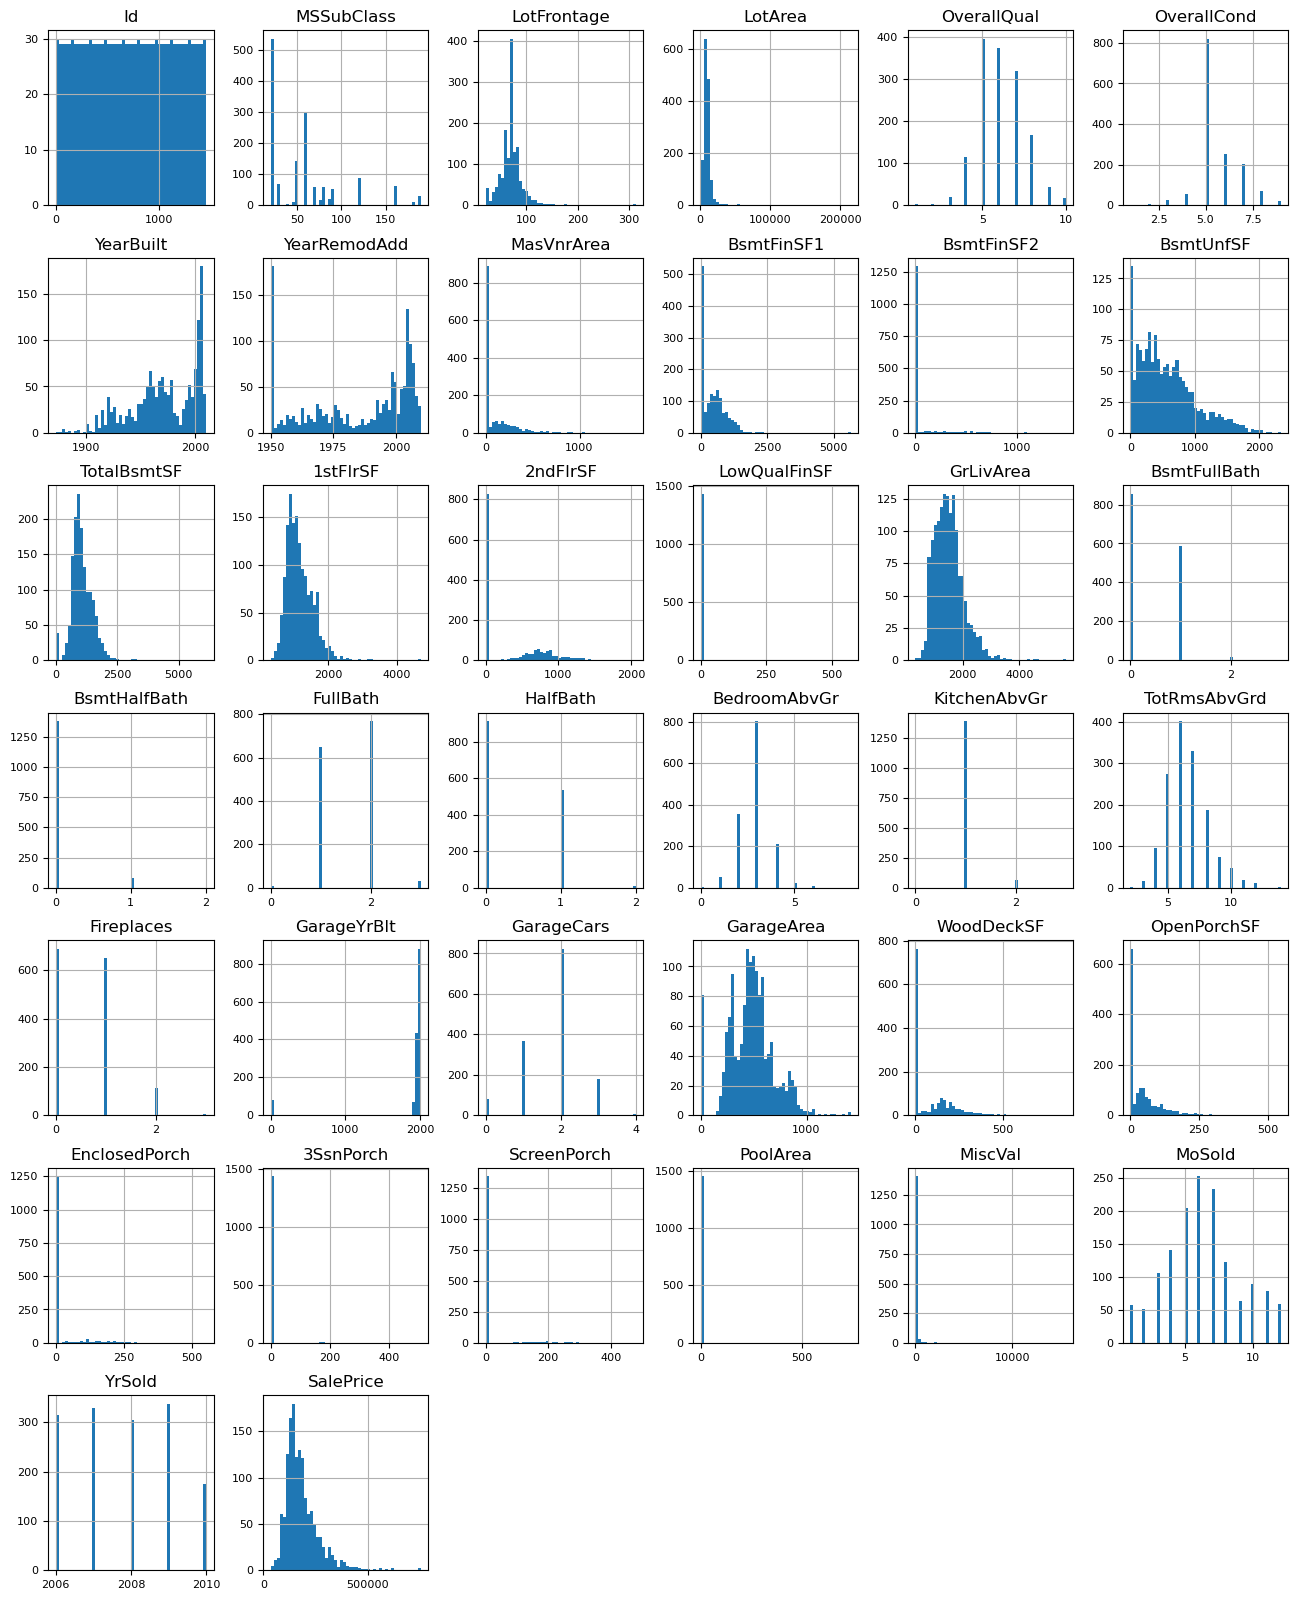

In [22]:
train_num.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8);


Claramente, nenhum dos dados numéricos segue uma distribuição normal, para checar a correlação, portanto, não podemos usar ANOVA, para resolvermos o problema, usaremos o teste Kruskal-Wallis

### Testes de Hipótese: Kruskal-Wallis

In [23]:
# List to store results
kruskal_results = []

# Loop through each numerical feature in train_num
for feature in train_num:
    # Perform Kruskal-Wallis test
    stat, p = kruskal(*[train[train['SalePrice'] == val][feature] for val in train['SalePrice'].unique()])
    
    # Append results to the list
    kruskal_results.append({'Feature': feature, 'Statistic': stat, 'p-value': p})

# Convert the results to a DataFrame for easy viewing
kruskal_results_df = pd.DataFrame(kruskal_results)

# Display the results
print(kruskal_results_df)

          Feature    Statistic       p-value
0              Id   636.335836  7.568665e-01
1      MSSubClass   634.655437  7.714751e-01
2     LotFrontage   776.654916  1.334104e-03
3         LotArea   827.189997  1.183469e-05
4     OverallQual  1164.702824  3.229874e-30
5     OverallCond   679.317044  3.120276e-01
6       YearBuilt  1019.727895  1.062126e-17
7    YearRemodAdd   909.233726  4.874876e-10
8      MasVnrArea   815.174301  4.061405e-05
9      BsmtFinSF1   835.524840  4.840408e-06
10     BsmtFinSF2   578.735438  9.911887e-01
11      BsmtUnfSF   701.036608  1.421595e-01
12    TotalBsmtSF   945.666121  2.328741e-12
13       1stFlrSF   918.608132  1.292440e-10
14       2ndFlrSF   793.811259  3.077675e-04
15   LowQualFinSF   649.751729  6.256524e-01
16      GrLivArea  1047.639717  6.534008e-20
17   BsmtFullBath   699.822308  1.495123e-01
18   BsmtHalfBath   586.706924  9.836130e-01
19       FullBath   996.258447  6.368525e-16
20       HalfBath   787.804615  5.228523e-04
21   Bedro

### Seleção de features numéricas

In [24]:
# Filter out only the significant variables based on a significance level (e.g., p-value < 0.05)
significant_variables = kruskal_results_df.loc[kruskal_results_df['p-value'] < 0.05, 'Feature'].tolist()

# Create a new DataFrame containing only the significant variables
new_train_num = train_num[significant_variables]

In [25]:
# Step 1: Filter out significant variables based on a significance level (e.g., p-value < 0.05)

significant_variables_test = [var for var in significant_variables if var != 'SalePrice']
new_test_num = test_num[significant_variables_test]
# Optionally, print the first few rows to verify
print(new_test_num.head())

   LotFrontage  LotArea  OverallQual  YearBuilt  YearRemodAdd  MasVnrArea  \
0         80.0    11622            5       1961          1961         0.0   
1         81.0    14267            6       1958          1958       108.0   
2         74.0    13830            5       1997          1998         0.0   
3         78.0     9978            6       1998          1998        20.0   
4         43.0     5005            8       1992          1992         0.0   

   BsmtFinSF1  TotalBsmtSF  1stFlrSF  2ndFlrSF  ...  FullBath  HalfBath  \
0       468.0        882.0       896         0  ...         1         0   
1       923.0       1329.0      1329         0  ...         1         1   
2       791.0        928.0       928       701  ...         2         1   
3       602.0        926.0       926       678  ...         2         1   
4       263.0       1280.0      1280         0  ...         2         0   

   BedroomAbvGr  TotRmsAbvGrd  Fireplaces  GarageYrBlt  GarageCars  \
0             2 

In [26]:
new_train_num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 22 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   LotFrontage   1460 non-null   float64
 1   LotArea       1460 non-null   int64  
 2   OverallQual   1460 non-null   int64  
 3   YearBuilt     1460 non-null   int64  
 4   YearRemodAdd  1460 non-null   int64  
 5   MasVnrArea    1460 non-null   float64
 6   BsmtFinSF1    1460 non-null   int64  
 7   TotalBsmtSF   1460 non-null   int64  
 8   1stFlrSF      1460 non-null   int64  
 9   2ndFlrSF      1460 non-null   int64  
 10  GrLivArea     1460 non-null   int64  
 11  FullBath      1460 non-null   int64  
 12  HalfBath      1460 non-null   int64  
 13  BedroomAbvGr  1460 non-null   int64  
 14  TotRmsAbvGrd  1460 non-null   int64  
 15  Fireplaces    1460 non-null   int64  
 16  GarageYrBlt   1460 non-null   float64
 17  GarageCars    1460 non-null   int64  
 18  GarageArea    1460 non-null 

In [27]:
new_test_num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 21 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   LotFrontage   1459 non-null   float64
 1   LotArea       1459 non-null   int64  
 2   OverallQual   1459 non-null   int64  
 3   YearBuilt     1459 non-null   int64  
 4   YearRemodAdd  1459 non-null   int64  
 5   MasVnrArea    1459 non-null   float64
 6   BsmtFinSF1    1459 non-null   float64
 7   TotalBsmtSF   1459 non-null   float64
 8   1stFlrSF      1459 non-null   int64  
 9   2ndFlrSF      1459 non-null   int64  
 10  GrLivArea     1459 non-null   int64  
 11  FullBath      1459 non-null   int64  
 12  HalfBath      1459 non-null   int64  
 13  BedroomAbvGr  1459 non-null   int64  
 14  TotRmsAbvGrd  1459 non-null   int64  
 15  Fireplaces    1459 non-null   int64  
 16  GarageYrBlt   1459 non-null   float64
 17  GarageCars    1459 non-null   float64
 18  GarageArea    1459 non-null 

### Checando multicolinearidade

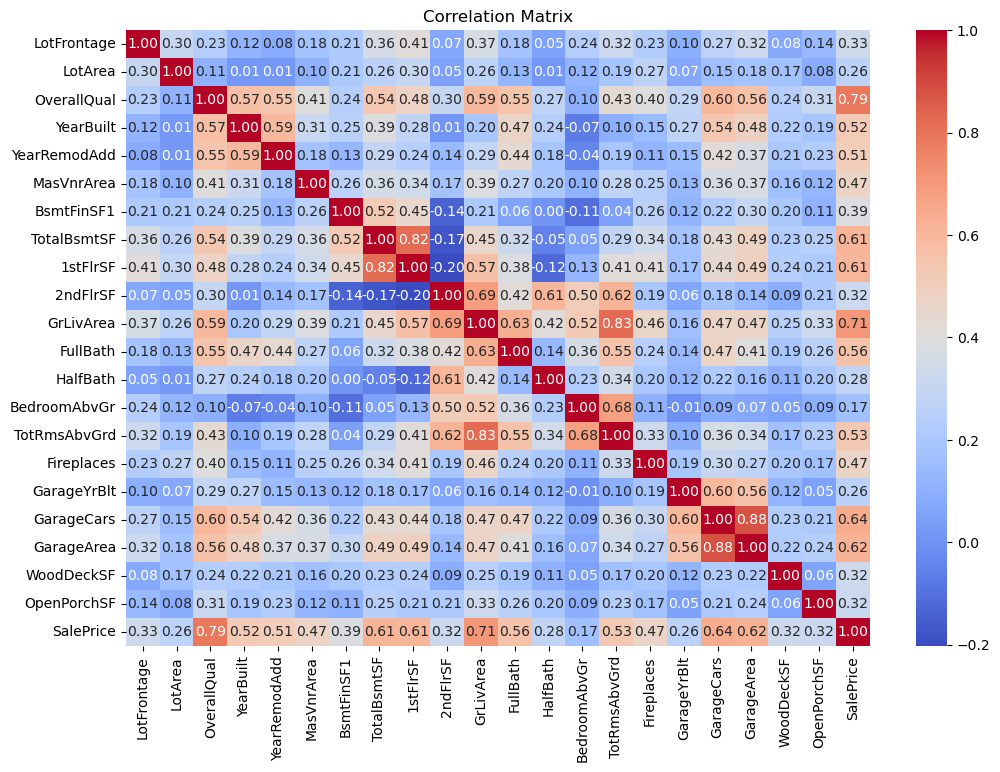

Highly correlated feature pairs:
('SalePrice', 'GrLivArea')
('TotalBsmtSF', '1stFlrSF')
('TotRmsAbvGrd', 'GrLivArea')
('OverallQual', 'SalePrice')
('SalePrice', 'OverallQual')
('GarageCars', 'GarageArea')
('1stFlrSF', 'TotalBsmtSF')
('GarageArea', 'GarageCars')
('GrLivArea', 'TotRmsAbvGrd')
('GrLivArea', 'SalePrice')


In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the correlation matrix
correlation_matrix = new_train_num.corr()

# Visualize the correlation matrix as a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

# Identify highly correlated features
threshold = 0.7  # Set your desired threshold
highly_correlated_pairs = (correlation_matrix.abs() > threshold) & (correlation_matrix != 1)
highly_correlated_features = set()
for col in correlation_matrix.columns:
    correlated_cols = correlation_matrix.index[highly_correlated_pairs[col]]
    highly_correlated_features.update([(col, correlated_col) for correlated_col in correlated_cols])

print("Highly correlated feature pairs:")
for pair in highly_correlated_features:
    print(pair)

In [29]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# Add a constant column to the features
X_with_const = add_constant(new_train_num)

# Create a DataFrame to store the VIF results
vif_data = pd.DataFrame()

# Calculate VIF for each feature
vif_data["Feature"] = X_with_const.columns
vif_data["VIF"] = [variance_inflation_factor(X_with_const.values, i) for i in range(X_with_const.shape[1])]

# Display the VIF DataFrame
print(vif_data)

         Feature           VIF
0          const  20369.195698
1    LotFrontage      1.376385
2        LotArea      1.249693
3    OverallQual      3.523214
4      YearBuilt      2.882164
5   YearRemodAdd      1.888859
6     MasVnrArea      1.389356
7     BsmtFinSF1      1.593294
8    TotalBsmtSF      3.970831
9       1stFlrSF     72.127745
10      2ndFlrSF     90.528621
11     GrLivArea    127.577023
12      FullBath      2.769273
13      HalfBath      2.138804
14  BedroomAbvGr      2.253915
15  TotRmsAbvGrd      4.462488
16    Fireplaces      1.518296
17   GarageYrBlt      1.759569
18    GarageCars      6.003490
19    GarageArea      5.291380
20    WoodDeckSF      1.164336
21   OpenPorchSF      1.199100
22     SalePrice      4.993603


## Concatenando as duas novas listas

In [30]:
train_final = pd.concat([new_train_cat, new_train_num], axis=1)

# Display the combined dataframe
train_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 65 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSZoning       1460 non-null   object 
 1   Street         1460 non-null   object 
 2   Alley          1460 non-null   object 
 3   LotShape       1460 non-null   object 
 4   LandContour    1460 non-null   object 
 5   Utilities      1460 non-null   object 
 6   LotConfig      1460 non-null   object 
 7   LandSlope      1460 non-null   object 
 8   Neighborhood   1460 non-null   object 
 9   Condition1     1460 non-null   object 
 10  Condition2     1460 non-null   object 
 11  BldgType       1460 non-null   object 
 12  HouseStyle     1460 non-null   object 
 13  RoofStyle      1460 non-null   object 
 14  RoofMatl       1460 non-null   object 
 15  Exterior1st    1460 non-null   object 
 16  Exterior2nd    1460 non-null   object 
 17  MasVnrType     1460 non-null   object 
 18  ExterQua

In [31]:
test_final = pd.concat([new_test_cat, new_test_num], axis=1)

# Display the combined dataframe
test_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 64 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSZoning       1459 non-null   object 
 1   Street         1459 non-null   object 
 2   Alley          1459 non-null   object 
 3   LotShape       1459 non-null   object 
 4   LandContour    1459 non-null   object 
 5   Utilities      1459 non-null   object 
 6   LotConfig      1459 non-null   object 
 7   LandSlope      1459 non-null   object 
 8   Neighborhood   1459 non-null   object 
 9   Condition1     1459 non-null   object 
 10  Condition2     1459 non-null   object 
 11  BldgType       1459 non-null   object 
 12  HouseStyle     1459 non-null   object 
 13  RoofStyle      1459 non-null   object 
 14  RoofMatl       1459 non-null   object 
 15  Exterior1st    1459 non-null   object 
 16  Exterior2nd    1459 non-null   object 
 17  MasVnrType     1459 non-null   object 
 18  ExterQua

## Modelagem

In [32]:
# Convert Pandas DataFrames to TensorFlow datasets with regression task
train_dataset = tfdf.keras.pd_dataframe_to_tf_dataset(
    train_final, label="SalePrice", task=tfdf.keras.Task.REGRESSION)
test_dataset = tfdf.keras.pd_dataframe_to_tf_dataset(test_final, task=tfdf.keras.Task.REGRESSION)


In [33]:
rf = tfdf.keras.RandomForestModel(task = tfdf.keras.Task.REGRESSION)
rf.compile # Optional, you can use this to include a list of eval metrics

Use /tmp/tmptwnr8yfx as temporary training directory


<bound method InferenceCoreModel.compile of <tensorflow_decision_forests.keras.RandomForestModel object at 0x7c593f2aa9d0>>

In [34]:
rf.fit(x=train_dataset)

Reading training dataset...
Training dataset read in 0:00:07.373625. Found 1460 examples.
Training model...


[INFO 2024-05-20T13:25:21.181088284+00:00 kernel.cc:1214] Loading model from path /tmp/tmptwnr8yfx/model/ with prefix 06e26ae32e974f5a


Model trained in 0:00:02.786192
Compiling model...


[INFO 2024-05-20T13:25:21.697495807+00:00 decision_forest.cc:661] Model loaded with 300 root(s), 137858 node(s), and 61 input feature(s).
[INFO 2024-05-20T13:25:21.697577246+00:00 abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 2024-05-20T13:25:21.697640973+00:00 kernel.cc:1046] Use fast generic engine


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model compiled.


In [35]:
# Evaluate the model with testing data (test_dataset)
mse = rf.evaluate(train_dataset)

# Print the Mean Squared Error (MSE)
print("Mean Squared Error (MSE):", mse)

2/2 [==============================] - 1s 33ms/step - loss: 0.0000e+00
Mean Squared Error (MSE): 0.0


In [36]:
from tensorflow_decision_forests.keras import GradientBoostedTreesModel

# Convert Pandas DataFrames to TensorFlow datasets with regression task
train_dataset = tfdf.keras.pd_dataframe_to_tf_dataset(
    train_final, label="SalePrice", task=tfdf.keras.Task.REGRESSION)
test_dataset = tfdf.keras.pd_dataframe_to_tf_dataset(test_final, task=tfdf.keras.Task.REGRESSION)

# Create a Gradient Boosted Trees model for regression task
gbt_model = GradientBoostedTreesModel(task=tfdf.keras.Task.REGRESSION)

# Compile the model with mean squared error (mse) as the evaluation metric
gbt_model.compile(metrics=["mse"])

# Fit the model with training data (train_dataset)
gbt_model.fit(train_dataset)

# Evaluate the model with testing data (test_dataset)
mse = gbt_model.evaluate(train_dataset)

# Print the Mean Squared Error (MSE)
print("Mean Squared Error (MSE):", mse)

Use /tmp/tmppzx448h9 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.935141. Found 1460 examples.
Training model...
Model trained in 0:00:02.027630
Compiling model...


[INFO 2024-05-20T13:25:33.150799235+00:00 kernel.cc:1214] Loading model from path /tmp/tmppzx448h9/model/ with prefix f9e8af9313044901
[INFO 2024-05-20T13:25:33.162334757+00:00 abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 2024-05-20T13:25:33.162558964+00:00 kernel.cc:1046] Use fast generic engine


Model compiled.
2/2 [==============================] - 0s 12ms/step - loss: 0.0000e+00 - mse: 164152224.0000
Mean Squared Error (MSE): [0.0, 164152224.0]


# Submission
Finally predict on the competition test data using the model.

In [37]:
test_file_path = "../input/house-prices-advanced-regression-techniques/test.csv"
test = pd.read_csv(test_file_path)
ids = test.pop('Id')

test_final_dataset = tfdf.keras.pd_dataframe_to_tf_dataset(test_final, task=tfdf.keras.Task.REGRESSION)

preds = gbt_model.predict(test_final_dataset)
output = pd.DataFrame({'Id': ids,
                       'SalePrice': preds.squeeze()})

output.head()

2/2 [==============================] - 1s 19ms/step


,Id,SalePrice
0,1461,125139.929688
1,1462,154942.468750
2,1463,187435.734375
3,1464,184114.765625
4,1465,202430.046875


In [38]:
sample_submission_df = pd.read_csv('../input/house-prices-advanced-regression-techniques/sample_submission.csv')
sample_submission_df['SalePrice'] = gbt_model.predict(test_final_dataset)
sample_submission_df.to_csv('/kaggle/working/submission.csv', index=False)
sample_submission_df.head()

2/2 [==============================] - 0s 18ms/step


,Id,SalePrice
0,1461,125139.929688
1,1462,154942.468750
2,1463,187435.734375
3,1464,184114.765625
4,1465,202430.046875
